In [34]:
import pandas as pd
import sys 
sys.path.append('..')
import numpy as np
import pandas as pd
from scipy.interpolate import RegularGridInterpolator
from scipy.fftpack import fftn, ifftn, fftfreq
from scipy.ndimage import gaussian_filter

In [3]:
%load_ext autoreload
%autoreload 2
from relation import Analysis
from analysis import *
from database import Magneticum

In [4]:
mcut=1e10
snap = '140'
box = ''

In [5]:
A140 = Analysis(50, snap,'',mcut_gal=mcut)

Galaxies mass cut applied: total-1360307, current-569385, removed-790922


In [6]:
df140 = A140.get_dataframe()

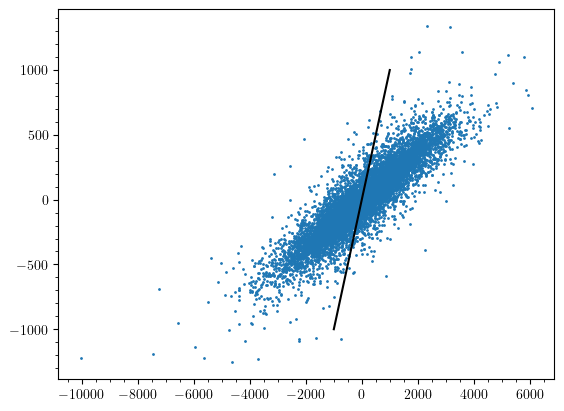

In [7]:
plt.scatter(df140.Vz/1e5, df140.vz,s=1)
plt.plot([-1000,1000],[-1000,1000],c='k')


In [8]:
clu_df = Magneticum(snap, box, 'cluster').dataframe
gal_df = Magneticum(snap, box, 'galaxies', mcut).dataframe

Galaxies mass cut applied: total-1360307, current-569385, removed-790922


In [90]:
clu_df

,UID,x[kpc/h],y[kpc/h],z[kpc/h],x_pix,y_pix,i_sector,m500c[Msol/h],r500c[kpc/h],gas_frac,star_frac,T[kev],Lx[1e44erg/s],Y500c,M_sat/M_cD,cshift[kpc],vx[km/s],vy[km/s],vz[km/s]
0,0,208707.3800,203892.310,349705.0300,9714,6893,6,1.032820e+15,1239.470,0.122792,0.028623,9.044580,23.543500,97.814776,0.025279,0.0,-191.69500,-64.8527,-197.449
1,1,314110.3100,24347.102,278058.4400,14620,15250,15,6.263050e+14,1049.090,0.116260,0.029199,6.373800,10.728500,55.243653,0.092982,0.0,-329.93000,45.8412,-256.902
2,2,83776.2580,206510.050,144915.3100,3899,6771,4,7.927850e+14,1134.840,0.121408,0.022461,8.076030,20.825900,79.072321,0.121626,0.0,5.47274,-169.6530,-124.361
3,3,183729.8300,193320.660,332756.0000,8551,7385,6,1.800290e+14,692.373,0.112743,0.026307,3.430610,1.339410,19.028983,0.706301,0.0,852.81600,639.8620,-434.947
4,4,327315.4100,233257.000,209403.9500,15235,5526,7,6.558460e+14,1065.330,0.114432,0.027987,6.241970,9.534250,54.074508,0.060787,0.0,17.03470,259.9550,-111.475
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10488,15109,245532.7300,47902.445,327681.7500,11428,14154,14,7.078800e+12,235.432,0.071753,0.027462,0.279663,0.011799,0.335735,0.557929,0.0,11.14620,-415.8640,-76.752
10489,15124,93769.9140,81091.062,252886.4400,4364,12609,13,7.258270e+12,237.408,0.064047,0.031599,0.330750,0.010331,0.357384,0.236394,0.0,35.06560,223.1580,-216.831
10490,15297,165208.6700,66284.719,57955.0550,7689,13298,13,7.186580e+12,236.624,0.051829,0.034700,0.393374,0.006633,0.342830,0.589790,0.0,-96.62210,111.1270,147.111
10491,15831,65617.1250,153918.000,3217.6663,3054,9219,8,7.527190e+12,240.301,0.078434,0.023595,0.315919,0.013869,0.423153,0.464481,0.0,-212.09800,247.3330,557.996


In [9]:
z = Magneticum(snap, box, 'cluster').z

In [30]:
box_size = 352

In [11]:
clus_pos = clu_df[['x[kpc/h]', 'y[kpc/h]', 'z[kpc/h]']]/1000

In [14]:
gala_pos = gal_df[['x[kpc/h]', 'y[kpc/h]', 'z[kpc/h]']]/1000

In [17]:
from astropy.cosmology import WMAP9 as cosmo

In [18]:
def scale_factor(z):
    return 1/(1+z)

In [111]:
H_a = cosmo.H(z)
a = scale_factor(z)
f_omega = cosmo.Om0**.545
factor =  (- H_a * f_omega * a).value/1.3

In [112]:
grid_size = 5

In [113]:
num_bins = int(box_size / grid_size)
x_edges = np.linspace(0, box_size, num_bins)
y_edges = np.linspace(0, box_size, num_bins)
z_edges = np.linspace(0, box_size, num_bins)

In [114]:
density, _ = np.histogramdd(gala_pos[['x[kpc/h]', 'y[kpc/h]', 'z[kpc/h]']].values, bins=(x_edges, y_edges, z_edges))

In [146]:
density = density/density.mean() - 1

In [147]:
smoothed_density = density#gaussian_filter(density, sigma=15)

In [148]:
delta_k = fftn(smoothed_density)


In [149]:
kx = fftfreq(delta_k.shape[0], d=grid_size / box_size) * 2.0 * np.pi
ky = fftfreq(delta_k.shape[1], d=grid_size / box_size) * 2.0 * np.pi
kz = fftfreq(delta_k.shape[2], d=grid_size / box_size) * 2.0 * np.pi
kx, ky, kz = np.meshgrid(kx, ky, kz, indexing='ij')

In [150]:
k = np.sqrt(kx**2 + ky**2 + kz**2)
k[0, 0, 0] = 1

In [151]:
v_kx = factor * (1j * kx / k**2) * delta_k
v_ky = factor * (1j * ky / k**2) * delta_k
v_kz = factor * (1j * kz / k**2) * delta_k

In [152]:
v_x = ifftn(v_kx).real
v_y = ifftn(v_ky).real
v_z = ifftn(v_kz).real


In [153]:
interp_vx = RegularGridInterpolator((x_edges[:-1], y_edges[:-1], z_edges[:-1]), v_x)
interp_vy = RegularGridInterpolator((x_edges[:-1], y_edges[:-1], z_edges[:-1]), v_y)
interp_vz = RegularGridInterpolator((x_edges[:-1], y_edges[:-1], z_edges[:-1]), v_z)


In [154]:
interp_vx(np.array([346,346,346]))

array([0.427418])

In [155]:
cvx,cvy,cvz = [],[],[]
for index, row in clus_pos.iterrows():
    pos = row[['x[kpc/h]', 'y[kpc/h]', 'z[kpc/h]']].values
    if np.any(pos>346):
        cvx.append(0)
        cvy.append(0)
        cvz.append(0)
    else:
        vx = interp_vx(pos)
        vy = interp_vy(pos)
        vz = interp_vz(pos)
        cvx.append(vx[0])
        cvy.append(vy[0])
        cvz.append(vz[0])

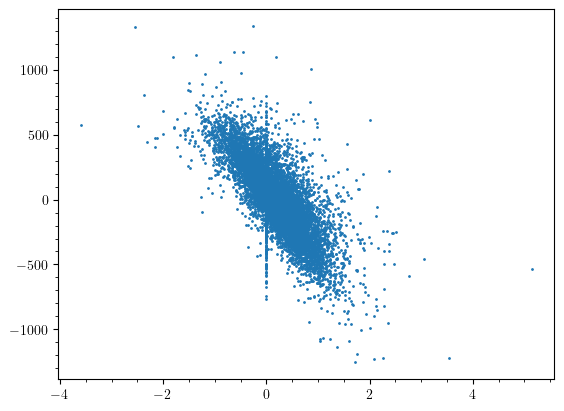

In [156]:
plt.scatter(cvz, clu_df['vz[km/s]'],s=1)